# DSCI 100 Group 177 - Group Project Report

### Title: Predicting the round of a tennis tournament in which a match takes place based on the match participants' ATP rankings and ranking points

In [1]:
# Please run this cell before continuing, installing packages if necessary.
library(tidyverse)
library(RColorBrewer)
library(tidymodels)

install.packages("themis")
library(themis)

install.packages("gridExtra")
library(gridExtra)

set.seed(2019)
# will continue to call set.seed(2019) throughout notebook, because consistent results were not being returned otherwise

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Introduction:

**Background:** The Association of Tennis Professionals (ATP) holds many single-elimination tournaments annually, and uses a merit-based method to rank all professional men’s tennis players based on their performances in ATP-sanctioned tournaments over the previous 12 months. The farther a player progresses in a tournament, the more points they will gain in the rankings. Therefore, each player has both a ranking and a number of points which determines their ranking relative to others. In each ATP tournament, a draw (or bracket) is set up which ensures that highly-ranked players are not likely to meet each other too early in the tournament, making it more likely that the later rounds will include highly-ranked players playing one another.

**Our question:** Can we predict the round of a tennis tournament (final, semi-final, quarter-final, round of 16, etc.) in which a match occurs using predictor variables such as the ranks of the winner and loser, their points in the ATP rankings, and statistics from the match?

**Our dataset:** Our dataset contains all of the match results for matches involving the top 500-ranked players from the years 2017-2019, with each row/observation corresponding to one match. The data for each match includes the competitors’ identities, rankings, ranking points, the round of the tournament in which the match occurred, and other metrics concerning the performance of the players in the match.

### Methods & Results:

***WRITE METHODS & RESULTS HERE***

In [2]:
# READING IN AND WRANGLING THE DATA

tennis_data_wrangled <- read_csv("https://raw.githubusercontent.com/ben-westmore/dsci-100-2022w1-group-177/main/atp2017-2019.csv",
                                 show_col_types = FALSE) |>
    mutate(round = as_factor(round),
           tourney_year = as.double(substr(tourney_date, 1, 4)),
           tourney_month = as.double(substr(tourney_date, 5, 6)),
           tourney_day = as.double(substr(tourney_date, 7, 8))) |>
    filter(round != 'BR',
           round != 'RR',
           tourney_year == 2019) |>
    select(-1, -tourney_date)

tennis_data_wrangled <- tennis_data_wrangled[, c(1:5, 49:51, 6:48)]    

tennis_data_wrangled$round <- factor(tennis_data_wrangled$round, levels = c("F", "SF", "QF", "R16", "R32", "R64", "R128"))


# CHECKING FOR BREAKDOWN OF MATCHES BY MATCH FORMAT (BEST OF 3 v BEST OF 5)

matches_by_format <- tennis_data_wrangled |>
    group_by(best_of) |>
    summarize(number_of_matches = n())

knitr::kable(matches_by_format,
             col.names = gsub("[_]", " ", names(matches_by_format)),
             "simple")


# FILTERING TO ONLY INCLUDE BEST OF 3 SET DATA, & MAKING A NEW STATISTIC TO TRY AS A PREDICTOR

tennis_data_wrangled <- tennis_data_wrangled |>
    filter(best_of == 3) |>
    mutate(w_over_l_point_ratio = winner_rank_points/loser_rank_points)

# head(tennis_data_wrangled)
# glimpse(tennis_data_wrangled)
# levels(tennis_data_wrangled$round)


# Notes:
# tennis_data_wrangled contains all of the data from best of 3 set matches in 2019 including all statistics,
# plus the new custom statistic 'w_over_l_point_ratio'

New names:
• `` -> `...1`




 best of   number of matches
--------  ------------------
       3                1881
       5                 476

### Table 1: Number of matches by format (best of 3 or 5 sets).

In [3]:
set.seed(2019)

# MAKING A NEW TIBBLE THAT ONLY INCLUDES THE PREDICTORS WE WILL TRY

tennis_analysis_data <- tennis_data_wrangled |>
    select(round,
           w_1stIn,
           w_df,
           l_1stIn,
           l_df,
           winner_rank,
           winner_rank_points,
           loser_rank,
           loser_rank_points,
           w_over_l_point_ratio) |>
    na.omit()

# head(tennis_analysis_data)


# SPLITTING THE DATA INTO TRAINING AND TESTING SETS

tennis_split <- initial_split(tennis_analysis_data, prop = 0.75, strata = round)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)


# MAKING A TABLE TO SHOW BREAKDOWN OF MATCHES BY ROUND IN THE TRAINING SET

matches_by_round <- tennis_train |>
    group_by(round) |>
    summarize(number_of_matches = n(),
              percentage_of_matches = (round((n()/nrow(tennis_train)) * 100, 2)))

knitr::kable(matches_by_round,
             col.names = gsub("[_]", " ", names(matches_by_round)),
             "simple")


# Notes:
# tennis_analysis_data includes only the target variable and predictor variable columns in tennis_data_wrangled
# that we plan on testing with forward selection, and all rows with NA values have been removed.
# The training and testing sets contain raw data from our potential predictors (not scaled and centered, not upsampled).



round    number of matches   percentage of matches
------  ------------------  ----------------------
F                       41                    2.94
SF                      77                    5.52
QF                     164                   11.76
R16                    330                   23.66
R32                    552                   39.57
R64                    188                   13.48
R128                    43                    3.08

### Table 2: Breakdown of matches by round in `tennis_train`.

Warning message:
“Removed 116 rows containing missing values (geom_point).”


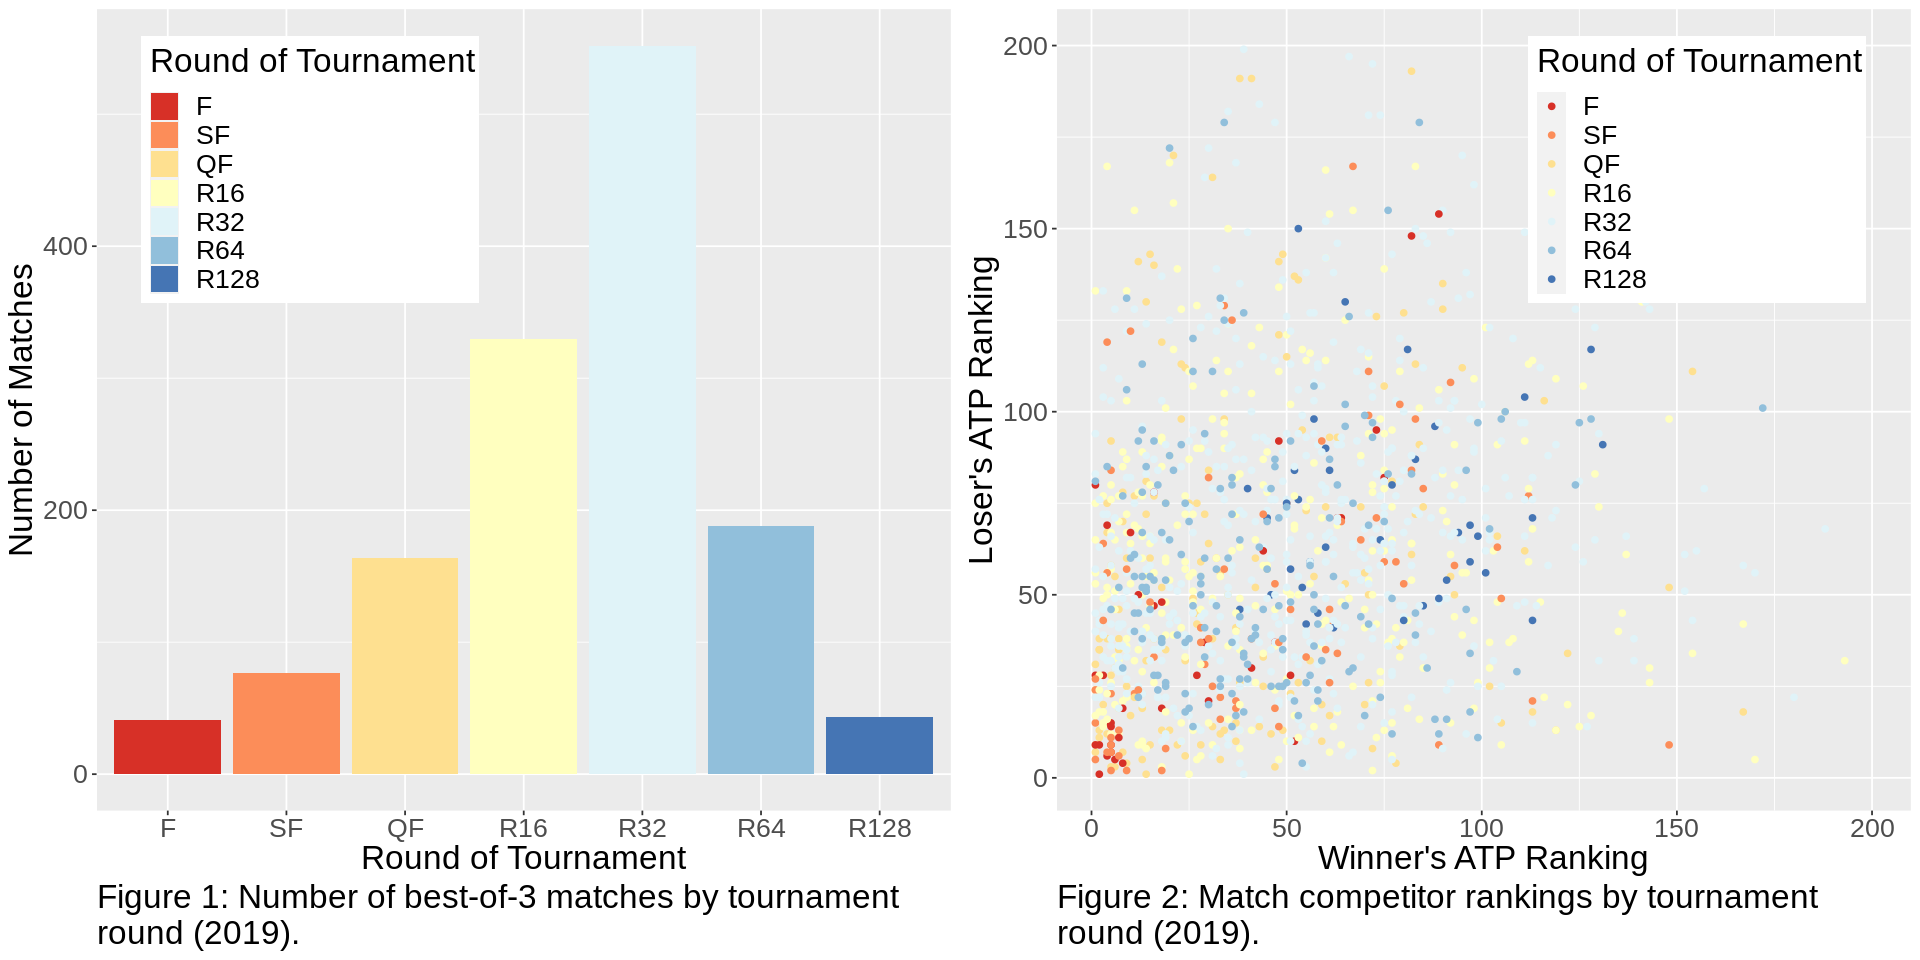

In [11]:
options(repr.plot.width = 16, repr.plot.height = 8)

# VISUALIZING THE MATCHES BY ROUND IN THE TRAINING SET

matches_by_round_plot <- ggplot(matches_by_round, aes(x = round, y = number_of_matches, fill = round)) +
    geom_bar(stat = "identity") +
    labs(x = "Round of Tournament",
         y = "Number of Matches",
         fill = "Round of Tournament",
         caption = "Figure 1: Number of best-of-3 matches by tournament\nround (2019).") +
    scale_fill_brewer(palette = "RdYlBu") +
    theme(text = element_text(size = 20),
          plot.caption = element_text(hjust = 0, size = 20),
          legend.position = c(0.25, 0.8))

# matches_by_round_plot


# VISUALIZING THE RANKINGS OF THE WINNER AND LOSER, COLOURED BY TOURNAMENT ROUND

rankings_vs_round_plot <- ggplot(tennis_train, aes(x = winner_rank, y = loser_rank, colour = round)) +
    geom_point() +
    labs(x = "Winner's ATP Ranking",
         y = "Loser's ATP Ranking",
         colour = "Round of Tournament",
         caption = "Figure 2: Match competitor rankings by tournament\nround (2019).") +
    lims(x = c(1, 200), y = c(1, 200)) +
    theme(text = element_text(size = 20),
          plot.caption = element_text(hjust = 0, size = 20),
          legend.position = c(0.75, 0.8)) +
    scale_color_brewer(palette = "RdYlBu")

# rankings_vs_round_plot

grid.arrange(matches_by_round_plot, rankings_vs_round_plot, ncol = 2)

In [5]:
set.seed(2019)

# UPSAMPLING THE TRAINING DATA FOR PURPOSES OF FORWARD SELECTION, CROSS-VALIDATION, AND PREDICTION

ups_recipe <- recipe(round ~ ., data = tennis_train) |>
  step_upsample(round, over_ratio = 0.35, skip = FALSE) |>
  prep()

upsampled_tennis_train <- bake(ups_recipe, tennis_train)


# MAKING A TABLE TO SHOW BREAKDOWN OF MATCHES BY ROUND IN THE TRAINING SET AFTER UPSAMPLING

upsampled_matches_by_round <- upsampled_tennis_train |>
  group_by(round) |>
  summarize(n = n(),
            percentage_of_matches = (round((n()/nrow(upsampled_tennis_train)) * 100, 2)))

knitr::kable(upsampled_matches_by_round,
             col.names = gsub("[_]", " ", names(upsampled_matches_by_round)),
             "simple")



round      n   percentage of matches
------  ----  ----------------------
F        193                   10.45
SF       193                   10.45
QF       193                   10.45
R16      330                   17.87
R32      552                   29.89
R64      193                   10.45
R128     193                   10.45

### Table 3: Breakdown of matches by round after upsampling.

In [6]:
# PERFORMING FORWARD SELECTION TO FIND BEST PREDICTOR VARIABLES
# COMMENTED OUT TO SAVE TIME

# potential_predictors <- colnames(upsampled_tennis_train |>
#                                      select(-round))

# cv_accuracies <- tibble(num_predictors = integer(),
#                         model_string = character(),
#                         accuracy = numeric())

# tennis_fs_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
#     set_engine("kknn") |>
#     set_mode("classification")

# tennis_vfold <- vfold_cv(upsampled_tennis_train, v = 5, strata = round)

# n_potential_preds <- length(potential_predictors)

# selected_preds <- c()

# for (i in 1:n_potential_preds) {
#     accs <- list()
#     models <- list()
#     for (j in 1:length(potential_predictors)) {
#         preds_new <- c(selected_preds, potential_predictors[[j]])
#         model_string <- paste("round", "~", paste(preds_new, collapse = "+"))

#         tennis_recipe <- recipe(as.formula(model_string), 
#                                 data = upsampled_tennis_train) |>
#                           step_scale(all_predictors()) |>
#                           step_center(all_predictors())

#         acc <- workflow() |>
#           add_recipe(tennis_recipe) |>
#           add_model(tennis_fs_spec) |>
#           tune_grid(resamples = tennis_vfold, grid = 10) |>
#           collect_metrics() |>
#           filter(.metric == "accuracy") |>
#           summarize(mx = max(mean))
#         acc <- acc$mx |> unlist()

#         accs[[j]] <- acc
#         models[[j]] <- model_string
#     }
#     jstar <- which.max(unlist(accs))
#     cv_accuracies <- cv_accuracies |> 
#       add_row(num_predictors = i, 
#               model_string = models[[jstar]], 
#               accuracy = accs[[jstar]])
#     selected_preds <- c(selected_preds, potential_predictors[[jstar]])
#     potential_predictors <- potential_predictors[-jstar]
# }
# cv_accuracies

# write_csv(cv_accuracies, "forward_selection.csv")

# shows no significant increase in accuracy for any predictors other than w_over_l_point_ratio

fs_accuracies <- read_csv("https://github.com/ben-westmore/dsci-100-2022w1-group-177/raw/main/forward_selection.csv",
                                 show_col_types = FALSE)
fs_accuracies

num_predictors,model_string,accuracy
<dbl>,<chr>,<dbl>
1,round ~ w_over_l_point_ratio,0.7634366
2,round ~ w_over_l_point_ratio+w_df,0.7747752
3,round ~ w_over_l_point_ratio+w_df+winner_rank,0.7743068
4,round ~ w_over_l_point_ratio+w_df+winner_rank+loser_rank,0.7720681
5,round ~ w_over_l_point_ratio+w_df+winner_rank+loser_rank+w_1stIn,0.7721093
6,round ~ w_over_l_point_ratio+w_df+winner_rank+loser_rank+w_1stIn+winner_rank_points,0.7693990
7,round ~ w_over_l_point_ratio+w_df+winner_rank+loser_rank+w_1stIn+winner_rank_points+loser_rank_points,0.7661777
8,round ~ w_over_l_point_ratio+w_df+winner_rank+loser_rank+w_1stIn+winner_rank_points+loser_rank_points+l_df,0.7645824
9,round ~ w_over_l_point_ratio+w_df+winner_rank+loser_rank+w_1stIn+winner_rank_points+loser_rank_points+l_df+l_1stIn,0.7596703


### Table 4: Forward selection accuracies.

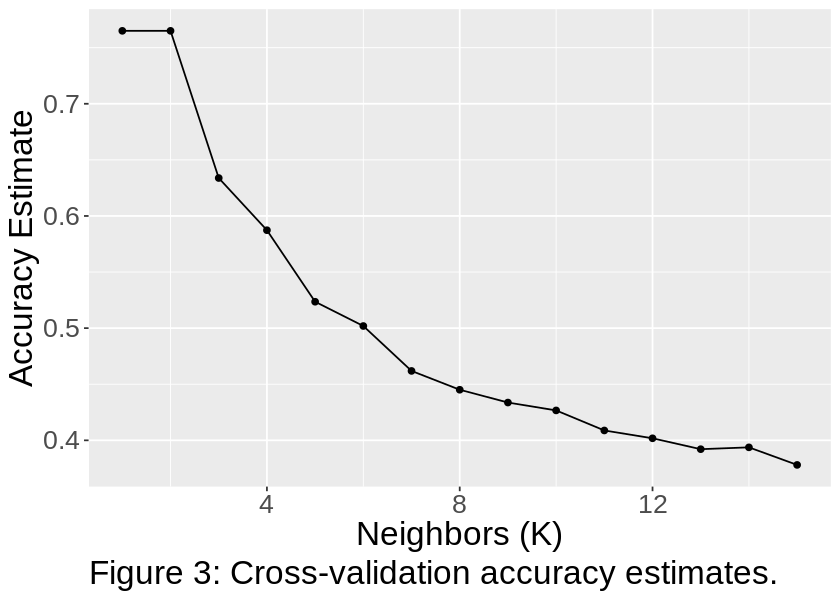

In [7]:
set.seed(2019)

# PERFORMING CROSS-VALIDATION AND COMPILING RESULTS INTO A DATAFRAME
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

tennis_cv_recipe <- recipe(round ~ winner_rank +
                                   winner_rank_points +
                                   loser_rank +
                                   loser_rank_points +
                                   w_over_l_point_ratio,
                           data = upsampled_tennis_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

tennis_cv_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

tennis_vfold <- vfold_cv(upsampled_tennis_train, v = 5, strata = round)

tennis_knn_results <- workflow() |>
    add_recipe(tennis_cv_recipe) |>
    add_model(tennis_cv_spec) |>
    tune_grid(resamples = tennis_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- tennis_knn_results |>
    filter(.metric == "accuracy")


# PLOTTING THE CROSS-VALIDATION ACCURACY ESTIMATES

options(repr.plot.width = 7, repr.plot.height = 5)

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors (K)",
         y = "Accuracy Estimate",
         caption = "Figure 3: Cross-validation accuracy estimates.") +
    theme(text = element_text(size = 20),
          plot.caption = element_text(hjust = 0, size = 20))

cross_val_plot

In [12]:
set.seed(2019)

# MAKING PREDICTIONS ON THE TEST SET AND COMPUTING ACCURACY

best_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

final_recipe <- recipe(round ~ winner_rank +
                       winner_rank_points +
                       loser_rank +
                       loser_rank_points +
                       w_over_l_point_ratio,
                       data = upsampled_tennis_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

best_k_fit <- workflow() |>
    add_recipe(final_recipe) |>
    add_model(best_k_spec) |>
    fit(upsampled_tennis_train)

best_k_predictions <- predict(best_k_fit, tennis_test) |>
    bind_cols(tennis_test) |>
    mutate(correct = ifelse(.pred_class == round, "yes", "no"))

best_k_metrics <- best_k_predictions |>
    metrics(truth = round, estimate = .pred_class) |>
    filter(.metric == "accuracy")

knitr::kable(best_k_metrics,
             col.names = c('metric', 'estimator', 'estimate'),
             "simple")



metric     estimator      estimate
---------  -----------  ----------
accuracy   multiclass    0.2526767

### Table 5: Classifier accuracy on test data.

Warning message:
“Removed 41 rows containing missing values (geom_point).”
Warning message:
“Removed 41 rows containing missing values (geom_point).”
Warning message:
“Removed 41 rows containing missing values (geom_point).”


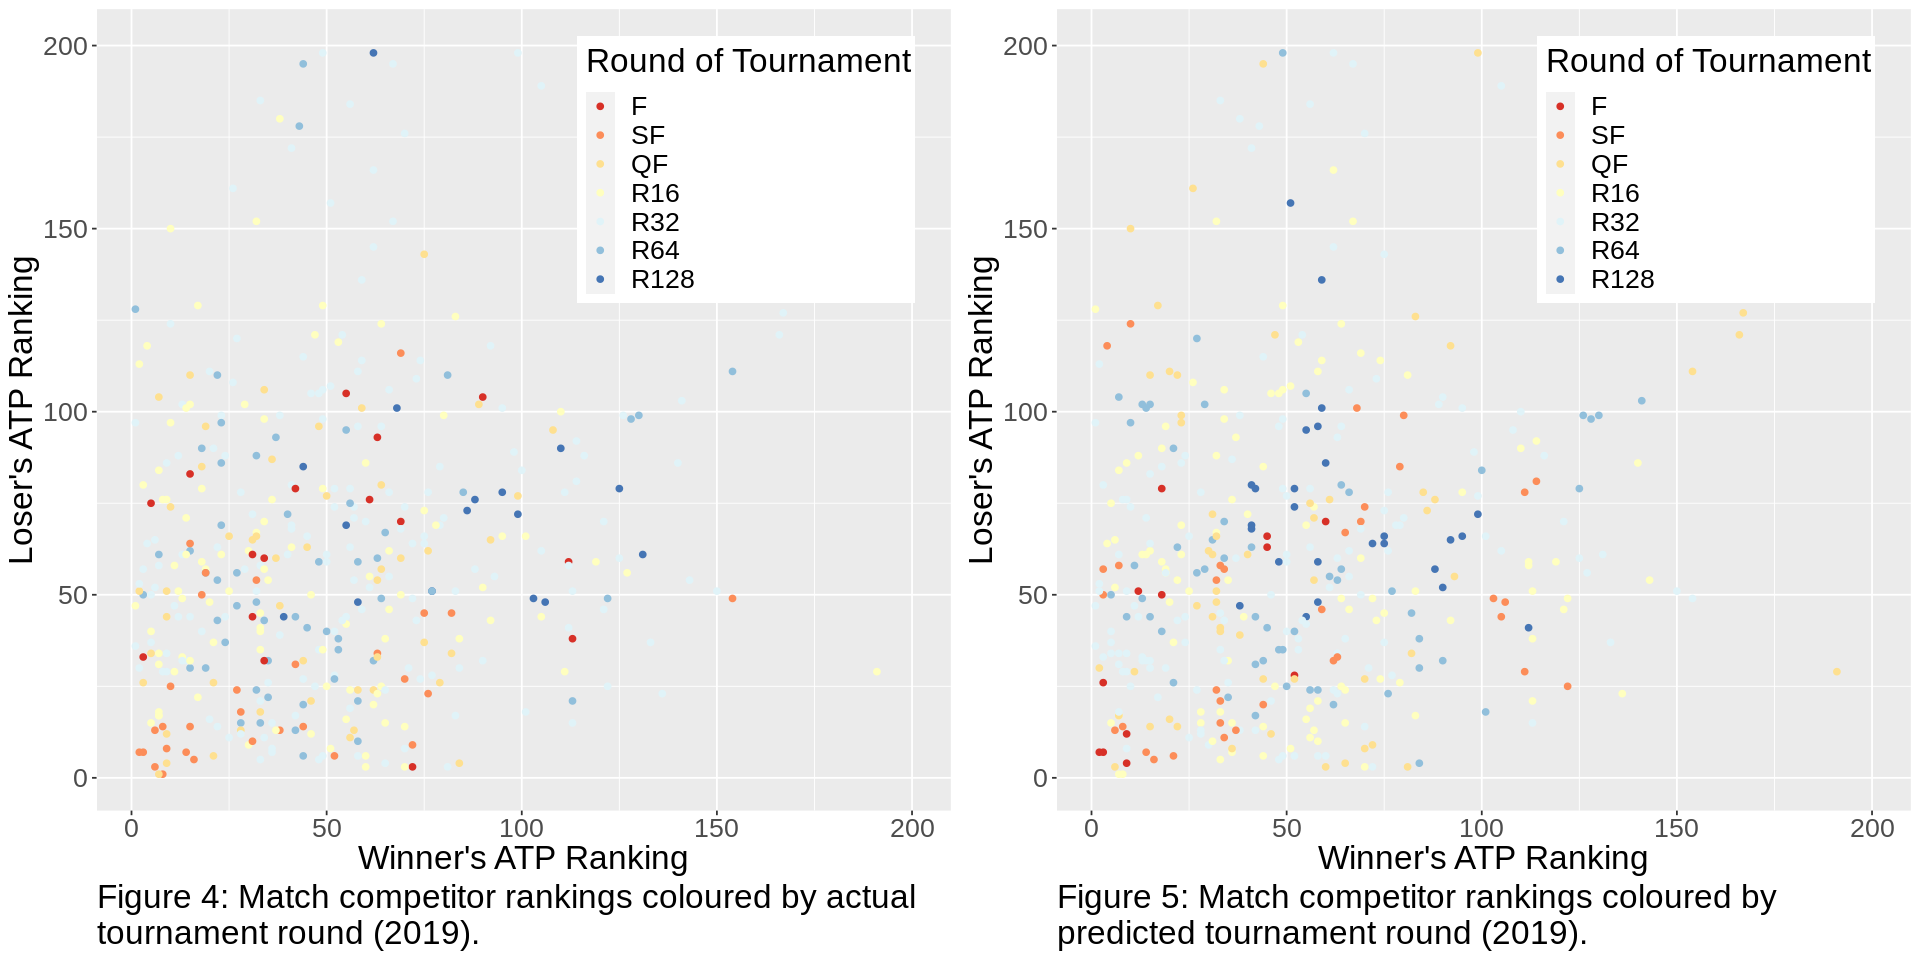

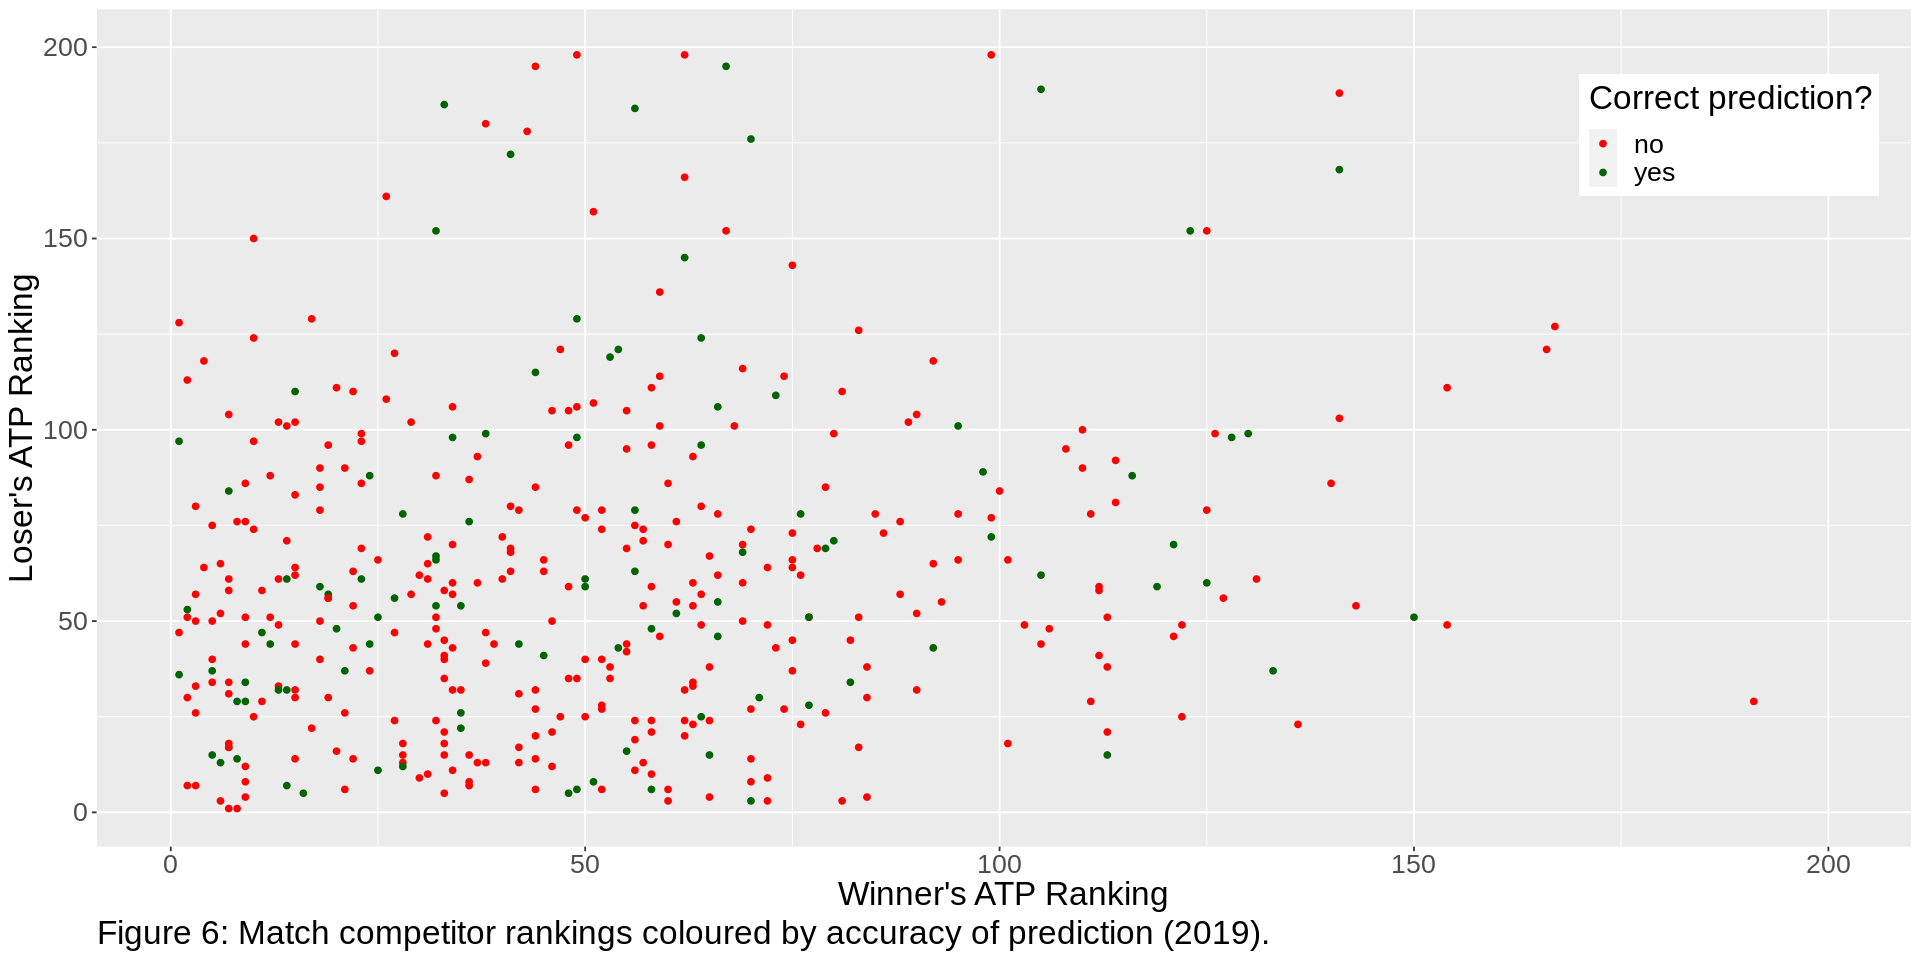

In [9]:
# VISUALIZING THE CLASSIFICATION RESULTS

options(repr.plot.width = 16, repr.plot.height = 8)

rankings_vs_round_plot_tennis_test <- ggplot(best_k_predictions, aes(x = winner_rank, y = loser_rank, colour = round)) +
    geom_point() +
    labs(x = "Winner's ATP Ranking",
         y = "Loser's ATP Ranking",
         colour = "Round of Tournament",
         caption = "Figure 4: Match competitor rankings coloured by actual\ntournament round (2019).") +
    lims(x = c(1, 200), y = c(1, 200)) +
    theme(text = element_text(size = 20),
          plot.caption = element_text(hjust = 0, size = 20),
          legend.position = c(0.76, 0.8)) +
    scale_color_brewer(palette = "RdYlBu")

rankings_vs_round_plot_pred <- ggplot(best_k_predictions, aes(x = winner_rank, y = loser_rank, colour = .pred_class)) +
    geom_point() +
    labs(x = "Winner's ATP Ranking",
         y = "Loser's ATP Ranking",
         colour = "Round of Tournament",
         caption = "Figure 5: Match competitor rankings coloured by\npredicted tournament round (2019).") +
    lims(x = c(1, 200), y = c(1, 200)) +
    theme(text = element_text(size = 20),
          plot.caption = element_text(hjust = 0, size = 20),
          legend.position = c(0.76, 0.8)) +
    scale_color_brewer(palette = "RdYlBu")

grid.arrange(rankings_vs_round_plot_tennis_test, rankings_vs_round_plot_pred, ncol = 2)

rankings_vs_round_plot_accuracy <- ggplot(best_k_predictions, aes(x = winner_rank, y = loser_rank, colour = correct)) +
    geom_point() +
    labs(x = "Winner's ATP Ranking",
         y = "Loser's ATP Ranking",
         colour = "Correct prediction?",
         caption = "Figure 6: Match competitor rankings coloured by accuracy of prediction (2019).") +
    lims(x = c(1, 200), y = c(1, 200)) +
    theme(text = element_text(size = 20),
          plot.caption = element_text(hjust = 0, size = 20),
          legend.position = c(0.9, 0.85)) +
    scale_color_manual(values = c("red", "darkgreen"))

rankings_vs_round_plot_accuracy

### Methods ***(REMOVE)***:

We will conduct our data analysis from a classification standpoint, using cross-validation to evaluate optimal model specifications and forward selection to evaluate the accuracy when using several different subsets of predictors to determine which variables we will use to predict the tournament round apart from player rankings and ranking points.

**Potential visualizations:** One way in which we may visualize our results would be a plot of the ratio of ranking points between the two players (winner ranking points/loser ranking points) to the round of the match, assuming that the greater the discrepancy between the players, the earlier in a tournament the match would be. Another possible visualization could be the winner’s rank plotted against the loser’s rank, coloured by the round of the match, with more advanced matches likely to be located near the origin of the plot.

### Discussion ***(CHANGE, this is from the proposal)***:

**Expected findings:** We expect to find that if both of the players in a match are highly ranked and/or have a large number of points in the ATP rankings, the match will be occurring in a later round (e.g. final or semifinal). Additionally, we predict that the bigger the discrepancy between the players’ points/rankings, the earlier in the tournament the match will be due to the nature of how the tournament draws are formed.

**Potential impact:** We are hoping that the insights gained from this project will help people build some intuition regarding how tennis tournaments are set up, and give them the ability to make an educated guess about the stage of a tournament they are likely to be watching based on the quality of the two players involved.

**Potential future questions:**
- Is there any way we could go a step further and predict the winner of a tournament based on the tournament draw and previous results? If not, what unconsidered factors might influence the results?
- Once we determine what the best predictor variables are for our question, will we be able to use them to predict other facts about a tournament?

### References

*ATP official rulebook*. (2022). ATP Tour. Retrieved December 6, 2022, from https://www.atptour.com/en/corporate/rulebook 

*ATP rankings: Pepperstone ATP rankings (singles)*. (2022). ATP Tour. Retrieved December 6, 2022, from https://www.atptour.com/en/rankings/singles 

Sackmann, J. (2022). *tennis_atp*. GitHub. https://github.com/JeffSackmann/tennis_atp

Timbers, T., Campbell, T., & Lee, M. (2022). *Data science: A first introduction*. https://datasciencebook.ca/

Wolff, R. (2020, August 26). *5 types of classification algorithms in machine learning*. MonkeyLearn. https://monkeylearn.com/blog/classification-algorithms/